In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

## 1) Setup

In [11]:
M = np.array([0.576, 0.32 , 0.94 , 0.736, 0.996, 0.74 , 0.884, 0.836, 0.748,
       0.768, 0.804, 0.78 , 0.724, 0.68 , 0.656, 0.68 , 0.688, 0.72 ,
       0.768, 0.764, 0.816, 0.74 , 0.336, 0.628, 0.544, 0.664, 0.628,
       0.664, 0.604, 0.596, 1.236, 0.516, 0.608, 0.588, 0.616, 0.612,
       0.612, 0.608, 0.592, 0.584, 0.588, 0.592, 0.624, 0.668, 0.66 ,
       0.696, 0.708, 0.688, 0.744, 0.844, 0.932, 0.964, 1.012, 0.956,
       0.488, 0.424, 1.028, 0.824, 0.916, 0.9  , 0.904, 0.892, 0.876,
       0.784, 0.42 , 0.332, 0.768, 0.744, 0.78 , 0.832, 0.48 , 0.408,
       0.896, 0.896, 0.784, 0.744, 0.68 , 0.768, 0.596, 0.724, 0.676,
       0.644, 0.688, 0.728, 0.74 , 0.724, 0.74 , 0.772, 0.816, 0.832,
       0.828, 0.82 , 0.808, 0.8  , 0.76 , 0.732, 0.692, 0.712, 0.772,
       0.8  ])

N = np.size(M)

sigVScalar = 1e-3
sigXScalar = 1e-2

d = 1
mu0 = np.array([-0.91861314, 0.60239937])
sigv = np.identity(d+1)*sigVScalar
sig0 = np.identity(d+1)*sigXScalar

precisionv = np.linalg.inv(sigv)
precision0 = np.linalg.inv(sig0)

alphahat = 41.3

h = np.ones((d+1, N))
for k in range(N):
    h[1:min(d+1, k)+1, k] = M[max(k-d,0):k][::-1]

## 2) Langevin Monte Carlo

In [112]:
print(np.exp(stats.multivariate_normal.logpdf(0, 0, 1)))
print(stats.multivariate_normal.pdf(0, 0, 1))


0.3989422804014327
0.3989422804014327


In [130]:
def lmcIteration(xk, eps, g):
    '''
    xk = current x vector
    eps = step size scalar
    g = gradient of f
    '''

    (n,) = xk.shape
    zk = np.random.multivariate_normal(np.zeros_like(xk), np.eye(n))
    x_plus = xk - eps**2/2 * g + eps*zk
    return x_plus

def logPx(x):
    (_, N) = x.shape
    logp = stats.multivariate_normal.logpdf(x[:,0], mu0, sig0)
    for j in range(1, N):
        logp += stats.multivariate_normal.logpdf(x[:,j], x[:,j-1], sigv)
    
    for j in range(N):
        beta = alphahat * np.exp(-h[:,j].T @ x[:,j])
        logp += stats.gamma.logpdf(M[j], a=alphahat, loc=0, scale=1/beta)
    return logp

def gradientX(x, prevX, postX, prePrec, postPrec, alphahat, y, h):
    print(-h.T@x)
    g = prePrec @ (x - prevX) - postPrec @ (postX - x) \
        + alphahat * h - alphahat * y * np.exp(- h.T @ x) * h
    
    return g

def accept(x_plus, xk, eps, g, gNew):
    (d1, N) = xk.shape
    qNewGivenOld = 0
    qOldGivenNew = 0
    for j in range(N):
        qNewGivenOld += stats.multivariate_normal.logpdf(x_plus[:,j], xk[:,j] - eps**2/2 * g[:,j], eps**2*np.eye(d1))
        qOldGivenNew += stats.multivariate_normal.logpdf(xk[:,j], x_plus[:,j] - eps**2/2 *gNew[:,j], eps**2*np.eye(d1))

    logPNew = logPx(x_plus)
    logPOld = logPx(xk)

    acceptProb = min(1, np.exp(logPNew + qOldGivenNew - logPOld - qNewGivenOld))
    acceptRes = stats.bernoulli.rvs(acceptProb)
    print(acceptProb, acceptRes)
    
    return acceptRes

In [128]:
S = 1000

def runLMC(ma = True):
    # initialize
    xSamps = np.zeros((d+1, N, S))
    xSamps[:,0,0] = np.random.multivariate_normal(mu0, sig0)

    eps = 0.01

    burnIn = 50

    for i in range(1,N):
        xSamps[:,i,0] = np.random.multivariate_normal(xSamps[:,i-1,0], sigv)

    k = 1
    kBurn = 0
    gNew = np.empty((d+1, N))

    gs = np.empty((d+1, N))
    for j in range(N):
        if j == 0:
            prevX = mu0; postX = xSamps[:,j+1,k-1]
            prePrec = precision0; postPrec = precisionv
        elif j == N-1:
            prevX = xSamps[:,j-1,k-1]; postX = xSamps[:,j,k-1]
            prePrec = precisionv; postPrec = precisionv
        else:
            prevX = xSamps[:,j-1,k-1]; postX = xSamps[:,j+1,k-1]
            prePrec = precisionv; postPrec = precisionv
        gs[:,j] = gradientX(xSamps[:,j,0], prevX, postX, prePrec, postPrec, alphahat, M[j], h[:,j])

    while k < S:
        newSamp = np.empty((d+1, N))

        for j in range(N):
            if j == 0:
                prevX = mu0; postX = xSamps[:,j+1,k-1]
                prePrec = precision0; postPrec = precisionv
            elif j == N-1:
                prevX = xSamps[:,j-1,k-1]; postX = xSamps[:,j,k-1]
                prePrec = precisionv; postPrec = precisionv
            else:
                prevX = xSamps[:,j-1,k-1]; postX = xSamps[:,j+1,k-1]
                prePrec = precisionv; postPrec = precisionv
            currX = xSamps[:,j,k-1]

            # gs[:,j] = gradientX(currX, prevX, postX, prePrec, postPrec, alphahat, M[j], h[:,j])
            newSamp[:,j] = lmcIteration(currX, eps, gs[:,j])
            
            gNew[:,j] = gradientX(newSamp[:,j], prevX, postX, prePrec, postPrec, alphahat, M[j], h[:,j])
        
        if kBurn < burnIn:
            kBurn += 1
        elif kBurn == burnIn:
            kBurn += 1
            xSamps[:,:,0] = newSamp
        else:
            if not ma or accept(newSamp, xSamps[:,:,k-1], eps, gs, gNew):
                xSamps[:,:,k] = newSamp
                gs = gNew.copy()
            else:
                xSamps[:,:,k] = xSamps[:,:,k-1].copy()
            k += 1

    return xSamps


In [131]:
xSamps = runLMC(ma = True)

0.25637497059762226
0.5917949989750411
0.7467552396243274
0.38049814690487826
0.5062498899989264
0.45146923039656467
0.6078223580287822
0.5557574316150826
0.49852012698922077
0.5765850932767684
0.5503618300685498
0.4831651495139157
0.4940873340532846
0.48084542497608207
0.42979346402462676
0.46499296652158517
0.45026862677817525
8.256202954342018e+52
0.44115422165645646
0.4523075429716917
0.41367058207820945
0.49242516399729325
0.42927143862936545
0.6520382402792083
0.5184052915702274
-1.4915153658666396e+137
0.41064786701758976
0.3930955481230473
0.3334720181637815
0.3538989144857356
0.36362590594870325
-0.06510496341137205
0.37479108676744
0.3208572231600306
0.4051903350238507
0.3514897165161839
0.40905677864535167
0.4149845629383566
0.4761201702079246
0.5149763312230784
0.5139753621949901
0.47681328139425455
0.45114235493475824
0.4504663764442275
0.4224819543719793
0.4392901715862794
0.4251966437500499
0.4052346874091143
0.3597988736783061
0.2948485673974516
0.2542143152134331
0.160

/var/folders/zy/3z5nf8ls6ll9ztbycw1jvq240000gn/T/ipykernel_32717/2801741627.py:27: RuntimeWarning: overflow encountered in exp
  + alphahat * h - alphahat * y * np.exp(- h.T @ x) * h


-6.098073049967401e+55
-0.0947444179895604
-0.05788361544746785
-0.1097372629215205
9.171652810583594e+105
-0.0462911155800207
-0.0668904006476199
-0.013478880629444924
-0.0718777658513103
0.25967066654489634
0.6052639490878201
0.7494683899899113
0.37967981670372586
0.5147737069151623
0.4958600782740332
0.6088151196555409
0.5532077371625423
0.48131852087640126
0.5658553220317077
0.5585429107563167
0.49978290172646445
0.4891375542468377
0.4944641787090199
0.44180105064206926
0.46353444295420465
0.4226947176547027
8.256202954342018e+52
0.454367490018124
0.4363366588110304
0.41664743845216906
0.4428750526821936
0.44680622660507424
0.6398399208791999
0.5255358338833482
-1.4915153658666396e+137
0.4062600662939666
0.42139012513502305
0.32313612684841725
0.3702317778888033
0.35701246426577254
-0.05663064095144516
0.37480752286223534
0.31847060888263135
0.3920870010910344
0.35345942928295554
0.42201573731420006
0.402723900970897
0.4937309068597643
0.49542237841363046
0.5227872210031669
0.47992

/Users/sabrinaliu/Library/Python/3.9/lib/python/site-packages/scipy/stats/_covariance.py:626: RuntimeWarning: invalid value encountered in matmul
  return x @ self._LP
/Users/sabrinaliu/Library/Python/3.9/lib/python/site-packages/scipy/stats/_multivariate.py:530: RuntimeWarning: overflow encountered in square
  maha = np.sum(np.square(cov_object.whiten(dev)), axis=-1)
/var/folders/zy/3z5nf8ls6ll9ztbycw1jvq240000gn/T/ipykernel_32717/2801741627.py:20: RuntimeWarning: overflow encountered in exp
  beta = alphahat * np.exp(-h[:,j].T @ x[:,j])
/Users/sabrinaliu/Library/Python/3.9/lib/python/site-packages/scipy/stats/_distn_infrastructure.py:2134: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/var/folders/zy/3z5nf8ls6ll9ztbycw1jvq240000gn/T/ipykernel_32717/2801741627.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  logp += stats.gamma.logpdf(M[j], a=alphahat, loc=0, scale=1/beta)
/var/folders/zy/3z5nf8ls6ll9ztbycw1jvq24

0.24623579579962662
0.6052527967024498
0.7837977605072809
0.39265277708345453
0.5919071647301919
0.47712742572574607
0.6269740788767116
0.48263616407665694
0.4592202372816075
0.5624717464027802
0.5272352258424079
0.49019619421062843
0.5086532409182696
0.43738472012349566
1.0200250743009765e+49
nan
nan
nan
nan
nan
1.1460281717146264e+49
0.39977928013056246
-2.5361244732107385e+133
-1.8033078794812613e+135
-5.592136367838842e+136
-1.819842643354863e+137
-5.912704694657629e+136
-3.3704682985542625e+135
-2.2756576354215276e+133
0.3992213300732798
0.32853822244168396
-0.018755136244870838
0.4295586115482775
0.31247810143896054
0.41076112886086397
0.38026038285317054
0.37113761064126377
0.41513726643411597
0.49915872925053373
0.5277835934464749
0.5168628778000836
0.4861081825858757
0.47214530117347675
0.44576030886523277
0.49755070763330106
0.4426580032604824
0.43088006195543177
0.3842279310356511
0.3582475016373432
0.30382556832711494
6.857281873377165e+63
nan
nan
nan
nan
nan
3.444890419800

KeyboardInterrupt: 

In [124]:
print(xSamps[0,plotN,:])

[-0.95489514 -0.95538718 -0.95924596 -0.95674391 -0.96994616 -0.98212232
 -0.97665543 -0.9791282  -0.98142689 -0.98175547 -0.99209993 -0.99472001
 -0.98792882 -0.98247195 -0.98351044 -0.98818472 -0.97261485 -0.96642083
 -0.95125818 -0.95722825 -0.96394759 -0.9423114  -0.95653514 -0.96651552
 -0.95981284         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan   

In [ ]:
# vals = np.linspace(-1, 1, 1000)
# x0s = np.zeros((d+1, N, vals.size))
# x1s = np.zeros((d+1, N, vals.size))
# x0s, x1s = np.meshgrid(vals, vals)
# ps = np.zeros_like(x0s)
# for i in range(vals.size):
#     for j in range(vals.size):
#         ps[i, j] = np.exp(logPx())

# plt.imshow(a, cmap='hot', interpolation='nearest')
# plt.show()

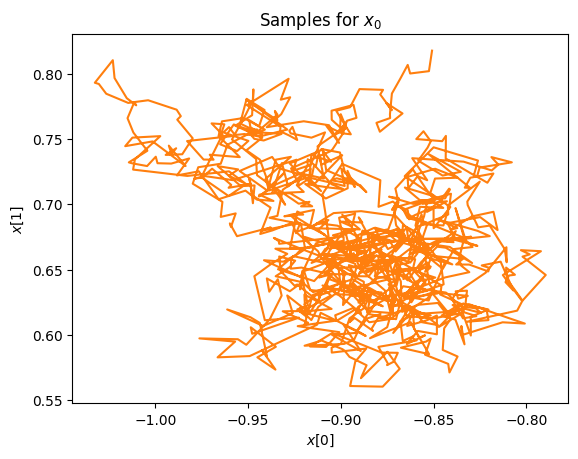

In [118]:

plotN = 0

# xSampsMala = xSamps.copy()
plt.plot(xSampsMala[0,plotN,:], xSampsMala[1,plotN,:])
plt.plot(xSamps[0,plotN,:], xSamps[1,plotN,:])
plt.xlabel(r"$x$[0]")
plt.ylabel(r"$x$[1]")
plt.title(rf"Samples for $x_{{{plotN}}}$")

# vecs = np.diff(xSamps)
# plt.quiver((xSamps[0,plotN,:-1], xSamps[1,plotN,:-1]), vecs[0, plotN,:], vecs[1,plotN,:])
plt.show()

In [85]:
xSamps[0,plotN,0]

0.0

## 3) Estimate expectation with LMC

In [150]:
def evalExpectationApprox(xSamps):
    (_, N, S) = xSamps.shape
    expectation = 0
    for k in range(S):
        betas = alphahat * np.exp(-np.sum(np.multiply(h, xSamps[:,:,k]), axis=0))
        for j in range(N):
            expectation += 1/S * np.log(stats.gamma.pdf(M[j], a=alphahat, loc=0, scale=1/betas[j]))
    return expectation

In [55]:
currXSamps = runLMC()


2.310620664555864e-18
4.083947733245621e-15
6.612461759197298e-11
1.270816051215929e-15
6.570863641030333e-22
2.2235184161529496e-15
4.722969521169277e-17
1.1131925566771764e-19
7.920401561506685e-16
3.558676148137718e-14
6.598624219920906e-15
2.812044965983292e-20
3.46099620640789e-14
8.100737917488029e-24
7.106752328993718e-07
5.895318985967387e-16
3.6006496077812096e-05
1.9912307984646738e-18
2.141239492061114e-18
7.244340950059345e-07
3.5109551586540807e-23
1.24881252120239e-16
4.3250801017747514e-17
4.046818264847655e-11
1.397549733345799e-19
1.5304745422399595e-19
3.157689735039406e-08
1.1999602543765564e-08
8.589560623763163e-19
1.3225443657661313e-08
8.791687396490426e-14
2.7826838340478295e-22
1.484473454167193e-10
5.509199461199803e-20
1.9929741504297515e-11
1.3260280057930192e-22
5.69814848069096e-23
2.5447188166394937e-26
3.682707921119357e-14
1.8648627086439414e-17
6.872669413590448e-16
1.90546310615851e-12
8.495990364682716e-25
4.053416879445328e-21
3.2745808691536465e-10

KeyboardInterrupt: 

In [149]:
expec = evalExpectationApprox(currXSamps)
print(expec)

6.199893333282091


In [151]:
numTrials = 100
expResults = np.zeros((numTrials,))

startTime = time.time()
for i in range(numTrials):
    if i % 10 == 0:
        currTime = time.time()
        print("Trial ", i, " Time (s): ", currTime - startTime)
        startTime = currTime
        
    currXSamps = runLMC()
    expResults[i] = evalExpectationApprox(currXSamps)

Trial  0  Time (s):  0.00036978721618652344
Trial  10  Time (s):  219.0518651008606
Trial  20  Time (s):  219.5293049812317
Trial  30  Time (s):  213.07683300971985
Trial  40  Time (s):  215.88222002983093
Trial  50  Time (s):  221.36953592300415
Trial  60  Time (s):  216.09003710746765
Trial  70  Time (s):  214.65997695922852
Trial  80  Time (s):  214.27222204208374
Trial  90  Time (s):  214.61978888511658


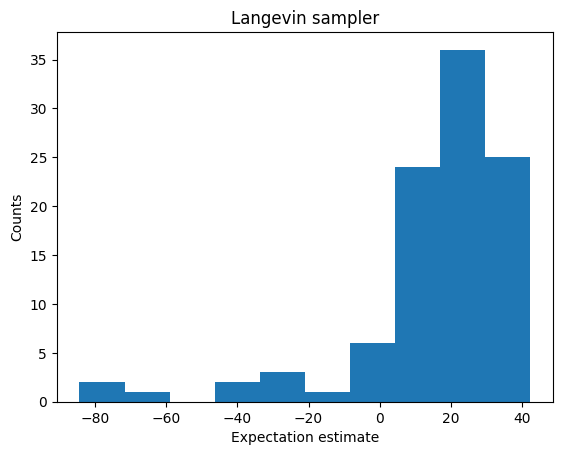

In [153]:
plt.hist(expResults)
plt.xlabel("Expectation estimate")
plt.ylabel("Counts")
plt.title("Langevin sampler")
plt.show()

## 4) Importance sampling

In [52]:
from importanceSamp import *

In [54]:
S = 1000
expectation = importanceSamp(S, alphahat, M, d, mu0, sig0, sigv)
print(expectation)

-102.47166969002235


## 5) Plot the density in background

In [ ]:
xVals = np.linspace((-1, 1, 1000))
idxOfInterest = 0
pdfVals = np.zeros_like((xVals.size, xVals.size))

def px0(x0):
    return (x0-mu0).T @ precision0

for x1Idx in range(xVals.size):
    for x2Idx in range(xVals.size):
        x1 = xVals[x1Idx]
        x2 = xVals[x2Idx]
        pdfVals[x1, x2] += 
        
logPx(x[])


In [8]:
k = 0
for i in range(6**100):
    k = i
    if i % 10000 == 0:
        print(i)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

KeyboardInterrupt: 